# Verification: 1D Wave Equation (FD)

This notebook verifies a **second-order** explicit finite-difference solver for the 1D wave equation:
\[
u_{tt} = c^2 u_{xx},\quad x\in(0,L),\ t>0
\]
with homogeneous Dirichlet boundary conditions and a manufactured exact solution.

**Goals**
- Confirm the implementation is stable (CFL ≤ 1).
- Demonstrate ~2nd-order convergence in space/time.


In [44]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 4)


## Exact solution (manufactured)
We use a standing-wave solution that satisfies Dirichlet BCs:
\[
u(x,t)=\sin\left(\frac{k\pi x}{L}\right)\cos\left(\frac{k\pi c t}{L}\right)
\]
So:
- \(f(x)=u(x,0)=\sin(k\pi x/L)\)
- \(g(x)=u_t(x,0)=0\)


In [45]:
def exact_solution(x, t, c=1.0, L=1.0, k=1):
    return np.sin(k*np.pi*x/L) * np.cos(k*np.pi*c*t/L)

def l2_error(u_num, u_ex, dx):
    return np.sqrt(dx * np.sum((u_num - u_ex)**2))

def linf_error(u_num, u_ex):
    return np.max(np.abs(u_num - u_ex))


## Solver (2nd-order in space + 2nd-order in time)
Discretization:
\[
\frac{u_i^{n+1}-2u_i^n+u_i^{n-1}}{\Delta t^2} = c^2\frac{u_{i+1}^n-2u_i^n+u_{i-1}^n}{\Delta x^2}
\]
Explicit update:
\[
u_i^{n+1}=2u_i^n-u_i^{n-1}+\lambda^2\left(u_{i+1}^n-2u_i^n+u_{i-1}^n\right),\quad \lambda=\frac{c\Delta t}{\Delta x}
\]
Initialization (Taylor at \(t=0\)):
\[
u_i^1=u_i^0+\Delta t\,g(x_i)+\frac{\lambda^2}{2}\left(u_{i+1}^0-2u_i^0+u_{i-1}^0\right)
\]


In [46]:
def wave_solver_fd(L=1.0, c=1.0, Nx=101, T=0.5, CFL=0.9, k=1):
    """
    Solves u_tt = c^2 u_xx on [0,L] with u(0,t)=u(L,t)=0.
    Uses manufactured exact solution for ICs:
        u(x,0)=sin(k*pi*x/L), u_t(x,0)=0.
    Returns x, u(x,T), dx, dt, Nt, lambda.
    """
    x = np.linspace(0.0, L, Nx)
    dx = x[1] - x[0]

    # CFL-based dt, then adjust to hit T exactly
    dt = CFL * dx / c
    Nt = int(np.ceil(T / dt))
    dt = T / Nt
    lam = c * dt / dx
    if lam > 1.0 + 1e-12:
        raise ValueError(f"CFL violated: lambda = {lam:.6f} > 1")

    # Initial conditions
    u0 = exact_solution(x, 0.0, c=c, L=L, k=k)
    g0 = np.zeros_like(x)

    # Enforce BCs
    u0[0] = 0.0
    u0[-1] = 0.0

    # u^1 initialization
    u1 = u0.copy()
    u1[1:-1] = (
        u0[1:-1]
        + dt * g0[1:-1]
        + 0.5 * lam**2 * (u0[2:] - 2.0*u0[1:-1] + u0[:-2])
    )
    u1[0] = 0.0
    u1[-1] = 0.0

    # March in time
    um1 = u0 
    u   = u1 
    up1 = np.zeros_like(u)

    for n in range(1, Nt):
        up1[1:-1] = (
            2.0*u[1:-1] - um1[1:-1]
            + lam**2 * (u[2:] - 2.0*u[1:-1] + u[:-2])
        )
        up1[0] = 0.0
        up1[-1] = 0.0
        um1, u, up1 = u, up1, um1

    return x, u, dx, dt, Nt, lam


## Single-run sanity check
Compare numerical vs exact at final time \(T\).

Nx=201, dx=5.0000e-03, dt=4.4643e-03, Nt=112, lambda=0.8929
L2 error  = 2.315916e-06
Linf error= 3.275199e-06


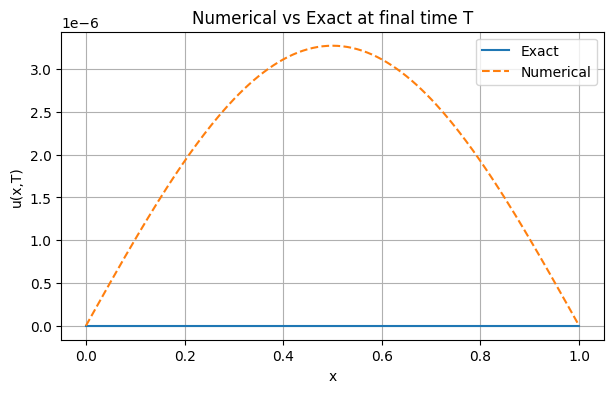

In [47]:
# Parameters
L = 1.0
c = 1.0
T = 0.50
k = 1
Nx = 201
CFL = 0.9

x, u_num, dx, dt, Nt, lam = wave_solver_fd(L=L, c=c, Nx=Nx, T=T, CFL=CFL, k=k)
u_ex = exact_solution(x, T, c=c, L=L, k=k)

print(f"Nx={Nx}, dx={dx:.4e}, dt={dt:.4e}, Nt={Nt}, lambda={lam:.4f}")
print(f"L2 error  = {l2_error(u_num, u_ex, dx):.6e}")
print(f"Linf error= {linf_error(u_num, u_ex):.6e}")

plt.plot(x, u_ex, label="Exact")
plt.plot(x, u_num, '--', label="Numerical")
plt.xlabel("x")
plt.ylabel("u(x,T)")
plt.title("Numerical vs Exact at final time T")
plt.legend()
plt.grid(True)
plt.show()


## Spatial convergence study (dt tied to dx via fixed CFL)
Refine \(\Delta x\) and keep a constant CFL so \(\Delta t\sim\Delta x\). Expected observed order: ~2.


In [48]:
def convergence_study_space(L=1.0, c=1.0, T=0.5, CFL=0.9, k=1, Nx_list=None):
    if Nx_list is None:
        Nx_list = [51, 101, 201, 401, 801]

    results = []
    prev_e2 = None
    prev_dx = None

    for Nx in Nx_list:
        x, u_num, dx, dt, Nt, lam = wave_solver_fd(L=L, c=c, Nx=Nx, T=T, CFL=CFL, k=k)
        u_ex = exact_solution(x, T, c=c, L=L, k=k)
        e2 = l2_error(u_num, u_ex, dx)
        einf = linf_error(u_num, u_ex)

        order = np.nan
        if prev_e2 is not None:
            order = np.log(prev_e2 / e2) / np.log(prev_dx / dx)

        results.append({
            "Nx": Nx, "dx": dx, "dt": dt, "Nt": Nt, "lambda": lam,
            "L2": e2, "Linf": einf, "order(L2)": order
        })
        prev_e2, prev_dx = e2, dx

    return results

space_results = convergence_study_space(L=L, c=c, T=T, CFL=CFL, k=k,
                                       Nx_list=[51, 101, 201, 401, 801])

for r in space_results:
    print(r)


{'Nx': 51, 'dx': np.float64(0.02), 'dt': 0.017857142857142856, 'Nt': 28, 'lambda': np.float64(0.8928571428571428), 'L2': np.float64(3.7065237423309743e-05), 'Linf': np.float64(5.2418161456917916e-05), 'order(L2)': nan}
{'Nx': 101, 'dx': np.float64(0.01), 'dt': 0.008928571428571428, 'Nt': 56, 'lambda': np.float64(0.8928571428571428), 'L2': np.float64(9.264191614263696e-06), 'Linf': np.float64(1.3101545424919341e-05), 'order(L2)': np.float64(2.0003297542003993)}
{'Nx': 201, 'dx': np.float64(0.005), 'dt': 0.004464285714285714, 'Nt': 112, 'lambda': np.float64(0.8928571428571428), 'L2': np.float64(2.315915578438225e-06), 'Linf': np.float64(3.2751992197506806e-06), 'order(L2)': np.float64(2.0000824293223856)}
{'Nx': 401, 'dx': np.float64(0.0025), 'dt': 0.002242152466367713, 'Nt': 223, 'lambda': np.float64(0.8968609865470851), 'L2': np.float64(5.585138744413413e-07), 'Linf': np.float64(7.898578957780622e-07), 'order(L2)': np.float64(2.05191763875784)}
{'Nx': 801, 'dx': np.float64(0.00125), 'd

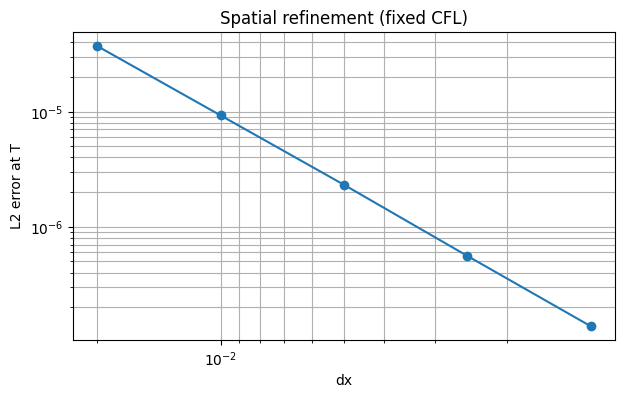

In [49]:
# Plot L2 error vs dx on log-log
dxs = np.array([r["dx"] for r in space_results])
e2s = np.array([r["L2"] for r in space_results])

plt.loglog(dxs, e2s, marker="o")
plt.xlabel("dx")
plt.ylabel("L2 error at T")
plt.title("Spatial refinement (fixed CFL)")
plt.grid(True, which="both")
plt.gca().invert_xaxis()
plt.show()


## Temporal convergence study (Nx very fine)
Keep \(\Delta x\) very small (large \(N_x\)) so spatial error is negligible, then refine \(\Delta t\) (by halving CFL) to observe ~2nd-order in time.


In [50]:
def convergence_study_time(L=1.0, c=1.0, T=0.5, k=1, Nx=2001, CFL_list=None):
    if CFL_list is None:
        CFL_list = [0.9, 0.45, 0.225, 0.1125]

    results = []
    prev_e2 = None
    prev_dt = None

    for CFL in CFL_list:
        x, u_num, dx, dt, Nt, lam = wave_solver_fd(L=L, c=c, Nx=Nx, T=T, CFL=CFL, k=k)
        u_ex = exact_solution(x, T, c=c, L=L, k=k)
        e2 = l2_error(u_num, u_ex, dx)
        einf = linf_error(u_num, u_ex)

        order = np.nan
        if prev_e2 is not None:
            order = np.log(prev_e2 / e2) / np.log(prev_dt / dt)

        results.append({
            "CFL": CFL, "dt": dt, "Nt": Nt, "lambda": lam,
            "L2": e2, "Linf": einf, "order(L2)": order
        })
        prev_e2, prev_dt = e2, dt

    return results

time_results = convergence_study_time(L=L, c=c, T=T, k=k, Nx=2001,
                                     CFL_list=[0.9, 0.45, 0.225, 0.1125])

for r in time_results:
    print(r)


{'CFL': 0.9, 'dt': 0.0004496402877697842, 'Nt': 1112, 'lambda': np.float64(0.8992805755395684), 'L2': np.float64(2.184418497398334e-08), 'Linf': np.float64(3.089234424381011e-08), 'order(L2)': nan}
{'CFL': 0.45, 'dt': 0.0002249212775528565, 'Nt': 2223, 'lambda': np.float64(0.449842555105713), 'L2': np.float64(9.10838376199242e-08), 'Linf': np.float64(1.2881200655344145e-07), 'order(L2)': np.float64(-2.06128324142595)}
{'CFL': 0.225, 'dt': 0.0001124859392575928, 'Nt': 4445, 'lambda': np.float64(0.22497187851518557), 'L2': np.float64(1.0841206082847693e-07), 'Linf': np.float64(1.5331780465445924e-07), 'order(L2)': np.float64(-0.2513398497207754)}
{'CFL': 0.1125, 'dt': 5.624929688378895e-05, 'Nt': 8889, 'lambda': np.float64(0.1124985937675779), 'L2': np.float64(1.1274625531128366e-07), 'Linf': np.float64(1.5944730609637584e-07), 'order(L2)': np.float64(-0.056563431968038126)}


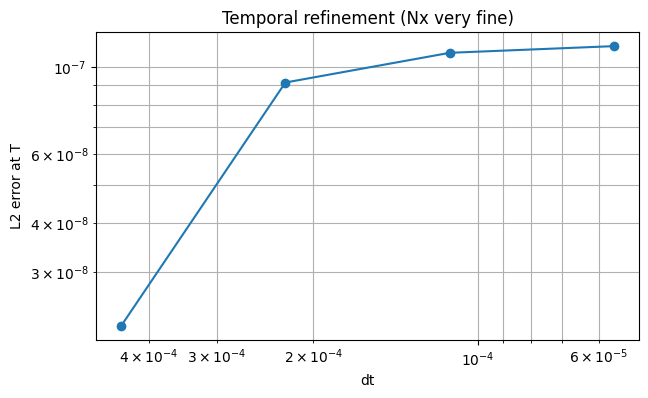

In [51]:
# Plot L2 error vs dt on log-log
dts = np.array([r["dt"] for r in time_results])
e2t = np.array([r["L2"] for r in time_results])

plt.loglog(dts, e2t, marker="o")
plt.xlabel("dt")
plt.ylabel("L2 error at T")
plt.title("Temporal refinement (Nx very fine)")
plt.grid(True, which="both")
plt.gca().invert_xaxis()
plt.show()


In [52]:
import numpy as np
import matplotlib.pyplot as plt


def u_exact(x, t, L=1.0, c=1.0, k=1):
    return np.sin(k*np.pi*x/L) * np.cos(k*np.pi*c*t/L)

def l2_err(u_num, u_ex, dx):
    return np.sqrt(dx * np.sum((u_num - u_ex)**2))

def linf_err(u_num, u_ex):
    return np.max(np.abs(u_num - u_ex))

def observed_order(err_coarse, err_fine, h_coarse, h_fine):
    return np.log(err_coarse/err_fine) / np.log(h_coarse/h_fine)


def wave_fd_solver(L=1.0, c=1.0, Nx=101, T=0.5, CFL=0.9, k=1):
    """
    Second-order centered in time + second-order centered in space explicit scheme.
    Initialization uses Taylor expansion with u_t(x,0)=0, and u_tt(x,0)=c^2 u_xx(x,0).
    """
    x = np.linspace(0.0, L, Nx)
    dx = x[1] - x[0]

    # Choose dt from CFL, then adjust so we land exactly on T
    dt = CFL * dx / c
    Nt = int(np.ceil(T / dt))
    dt = T / Nt
    lam = c * dt / dx

    if lam > 1.0 + 1e-12:
        raise ValueError(f"CFL violated: lambda={lam:.4f} > 1. Reduce dt or increase Nx.")

    # Initial displacement and velocity from exact solution
    u0 = u_exact(x, 0.0, L=L, c=c, k=k)
    g0 = np.zeros_like(x) 

    # Enforce Dirichlet
    u0[0] = 0.0
    u0[-1] = 0.0

    u1 = u0.copy()
    u1[1:-1] = (
        u0[1:-1]
        + dt * g0[1:-1]
        + 0.5 * lam**2 * (u0[2:] - 2.0*u0[1:-1] + u0[:-2])
    )
    u1[0] = 0.0
    u1[-1] = 0.0

    um1 = u0 
    u = u1  
    up1 = np.zeros_like(u)

    for _ in range(1, Nt):
        up1[1:-1] = (
            2.0*u[1:-1] - um1[1:-1]
            + lam**2 * (u[2:] - 2.0*u[1:-1] + u[:-2])
        )
        up1[0] = 0.0
        up1[-1] = 0.0
        um1, u, up1 = u, up1, um1 

    return x, u, dx, dt, Nt


def spatial_convergence(L=1.0, c=1.0, T=0.5, k=1, CFL=0.9, Nx_list=None):
    """
    Refine Nx (dx decreases). Keep CFL fixed so dt ~ dx.
    Expect observed order ~ 2.
    """
    if Nx_list is None:
        Nx_list = [51, 101, 201, 401, 801]

    results = []
    prev = None

    for Nx in Nx_list:
        x, u_num, dx, dt, Nt = wave_fd_solver(L=L, c=c, Nx=Nx, T=T, CFL=CFL, k=k)
        u_ex = u_exact(x, T, L=L, c=c, k=k)

        e2 = l2_err(u_num, u_ex, dx)
        einf = linf_err(u_num, u_ex)

        p = np.nan
        if prev is not None:
            p = observed_order(prev["e2"], e2, prev["dx"], dx)

        row = {"Nx": Nx, "dx": dx, "dt": dt, "Nt": Nt, "e2": e2, "einf": einf, "p": p}
        results.append(row)
        prev = row

    return results

def temporal_convergence(L=1.0, c=1.0, T=0.5, k=1, Nx_fine=2001, CFL_list=None):
    """
    Keep Nx very fine so spatial error is small. Refine dt by reducing CFL.
    Expect observed order ~ 2 in time.
    """
    if CFL_list is None:
        CFL_list = [0.9, 0.45, 0.225, 0.1125]

    results = []
    prev = None

    for CFL in CFL_list:
        x, u_num, dx, dt, Nt = wave_fd_solver(L=L, c=c, Nx=Nx_fine, T=T, CFL=CFL, k=k)
        u_ex = u_exact(x, T, L=L, c=c, k=k)

        e2 = l2_err(u_num, u_ex, dx)
        einf = linf_err(u_num, u_ex)

        p = np.nan
        if prev is not None:
            p = observed_order(prev["e2"], e2, prev["dt"], dt)

        row = {"CFL": CFL, "dt": dt, "Nt": Nt, "e2": e2, "einf": einf, "p": p}
        results.append(row)
        prev = row

    return results

def print_spatial_table(rows):
    print("\nSpatial convergence (fixed CFL):")
    print(f"{'Nx':>6} {'dx':>12} {'dt':>12} {'Nt':>8} {'L2 err':>14} {'Linf err':>14} {'p':>8}")
    for r in rows:
        print(f"{r['Nx']:6d} {r['dx']:12.4e} {r['dt']:12.4e} {r['Nt']:8d} "
              f"{r['e2']:14.6e} {r['einf']:14.6e} {r['p']:8.4f}")

def print_temporal_table(rows):
    print("\nTemporal convergence (Nx fine):")
    print(f"{'CFL':>8} {'dt':>12} {'Nt':>8} {'L2 err':>14} {'Linf err':>14} {'p':>8}")
    for r in rows:
        print(f"{r['CFL']:8.4f} {r['dt']:12.4e} {r['Nt']:8d} "
              f"{r['e2']:14.6e} {r['einf']:14.6e} {r['p']:8.4f}")

def plot_convergence_x(rows, filename="space_convergence.png"):
    dx = np.array([r["dx"] for r in rows])
    e2 = np.array([r["e2"] for r in rows])

    plt.figure()
    plt.loglog(dx, e2, marker="o")
    plt.xlabel(r"$\Delta x$")
    plt.ylabel(r"$\|e\|_2$")
    plt.title("Spatial Convergence (fixed CFL)")
    plt.grid(True, which="both")
    plt.savefig(filename, dpi=200, bbox_inches="tight")
    plt.close()

def plot_convergence_t(rows, filename="time_convergence.png"):
    dt = np.array([r["dt"] for r in rows])
    e2 = np.array([r["e2"] for r in rows])

    plt.figure()
    plt.loglog(dt, e2, marker="o")
    plt.xlabel(r"$\Delta t$")
    plt.ylabel(r"$\|e\|_2$")
    plt.title("Temporal Convergence (Nx fine)")
    plt.grid(True, which="both")
    plt.savefig(filename, dpi=200, bbox_inches="tight")
    plt.close()


if __name__ == "__main__":
    L = 1.0
    c = 1.0
    T = 0.50
    k = 1

    # Spatial study settings
    CFL_space = 0.9
    Nx_list = [51, 101, 201, 401, 801]

    # Temporal study settings
    Nx_fine = 2001
    CFL_list = [0.9, 0.45, 0.225, 0.1125]

    # Run studies
    space_rows = spatial_convergence(L=L, c=c, T=T, k=k, CFL=CFL_space, Nx_list=Nx_list)
    time_rows  = temporal_convergence(L=L, c=c, T=T, k=k, Nx_fine=Nx_fine, CFL_list=CFL_list)

    # Print tables
    print_spatial_table(space_rows)
    print_temporal_table(time_rows)


Spatial convergence (fixed CFL):
    Nx           dx           dt       Nt         L2 err       Linf err        p
    51   2.0000e-02   1.7857e-02       28   3.706524e-05   5.241816e-05      nan
   101   1.0000e-02   8.9286e-03       56   9.264192e-06   1.310155e-05   2.0003
   201   5.0000e-03   4.4643e-03      112   2.315916e-06   3.275199e-06   2.0001
   401   2.5000e-03   2.2422e-03      223   5.585139e-07   7.898579e-07   2.0519
   801   1.2500e-03   1.1236e-03      445   1.370450e-07   1.938109e-07   2.0269

Temporal convergence (Nx fine):
     CFL           dt       Nt         L2 err       Linf err        p
  0.9000   4.4964e-04     1112   2.184418e-08   3.089234e-08      nan
  0.4500   2.2492e-04     2223   9.108384e-08   1.288120e-07  -2.0613
  0.2250   1.1249e-04     4445   1.084121e-07   1.533178e-07  -0.2513
  0.1125   5.6249e-05     8889   1.127463e-07   1.594473e-07  -0.0566
